In [1]:
# This is imported for proper rendering of Latex in notebook
from IPython.display import display, Math, Latex

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(306)
plt.style.use('seaborn')

# Perceptron

In this notebook, we will implement perceptron algorithm from scratch.

## Perceptron Components:

### Training Data
- Feature matrix: $X_{n \times (m+1)}$ includes a dummy feature $x_0$ that set is set to $1$.
- Label vector: $y_{n \times 1}$

> Note: Perceptron can only solve only **Binary Classification** problems.

### Model
$$h_w : y = \text{sign} (w^T \phi(x)) = \text{sign}(z)$$
where
- $w$ is a weight vector in $\mathbb{R}^{m+1}$
- $\text{sign}(z) = 1$ if $z \ge 0$ and $-1$ otherwise

### Loss Function
$$J(w) = \sum^{n}_{i=1} e^{(i)} = \sum^{n}_{i=1} \text{max} (-h_w (x^{(i)})y^{(i)}, 0)$$

### Optimization Procedure (Perceptron update rule)
1. Initialize $w^{(0)} = 0$
2. For each training example ($x^{(i)}, y^{(i)}$):
    - $\hat y ^{(i)} = \text{sign}(w^T \phi(x^{(i)}))$ [Calculate the output value]
    - $w^{(t+1)} := w^{(t)} + \alpha (y^{(i)} - \hat y ^{(i)}) \phi(x^{(i)})$ [Update the weights]

> Note: Linearly separable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

### Evaluation metrics
- Confusion matrix
- Precision/Recall/F1 Score

## Implementation

We will use polynomial transformation code from previous colab for feature transformation.

In [4]:
##@title Polynomial Transform
import itertools,functools

def get_combinations(x, degree):
    '''
    Return successive r-length combinations of elements in the iterable allowing individual elements to have successive repeats.

    combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC"
    '''
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    '''
    reduce(function, sequence[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.

    For example: 
    reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). 
    
    If initial is present, it is placed before the items of the sequence in the calculation, and serves as a default when the sequence is empty.

    reduce(lambda x,y: x*y, [1, 2, 3, 4, 5]) calculates ((((1*2)*3)*4)*5).
    '''
    return functools.reduce(lambda x, y: x*y, items)

def polynomial_transform(x, degree, logging=False):
    '''
    Steps for generating polynomial transformations of degree M ---
        
        1. Generate combination of input features of lengths = {0,1,...,M}.
        
        2. Perform multiplication operation between features to obtain the required new features.
    
    logging: Bool - True to print all the combinations and their products.
    '''
    
    # If 'x' is 1-dim, it is first converted to a feature matrix.
    # [1,2,3,4] to [[1],[2],[3],[4]]
    if x.ndim == 1:
        x = x[:,None]
    
    # Transpose of feature matrix
    x_t = x.transpose()

    # Populates 1's as first feature for each example, the degree 0 feature.
    features  = [np.ones(len(x))]

    if logging:
        print("Input: ",x)
    
    # for each degree d
    for d in range(1, degree+1):
        # generate combinations of degree d
        for x in get_combinations(x_t, d):
            # take product of no.s in x, and combine them into a single feature
            features.append(compute_new_feature(x))
            if logging:
                print(x,compute_new_feature(x), sep = ': ')
    
    if logging:
        print("Output: ", np.asarray(features).transpose())
    
    return np.asarray(features).transpose()

### Perceptron Class

In [5]:
class Perceptron:
    '''Implements perceptron class.

    It uses the following class variables:

    w: stores the final weight vector
    w_all: stores all weight vectors in training iterations
    error_all: stores all errors in training iterations
    '''
    def __init__(self):
        return
    
    def predict(self, X):
        ''' Predicts labels for input feature matrix X.
        '''
        z = X @ self.w
        # z>= 0 return a boolean array, and we return 1 for True and -1 for False
        return np.where(z>=0, 1, -1)
    
    def loss(self, X, y):
        '''Calculates loss.

        Calculates loss due to current weight vector w on feature matrix X and label vector y.

        Args:
            x: Feature matrix
            y: Label vector
        
        Returns:
            None
        '''
        return np.sum(np.maximum(
            -1*self.predict(X)*y,
            np.zeros(y.shape[0])
        ))
    
    def train(self, X, y, epochs=10, lr=0.001):
        '''Implementsthe perceptron update rule.

        Args:
            x: Feature matrix
            y: Label vector
            epochs: Number of epochs
            lr: Learning rate
        
        Returns:
            None
        '''
        # Initialization to all zeros vector
        self.w = np.zeros(X.shape[1])
        
        self.error_all = []
        self.w_all = []

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X,y):
                self.w += lr * (target - self.predict(xi)) * xi
                errors += (max(
                    -1 * self.predict(xi) * target,
                    0
                ))
            
            self.error_all.append(errors)
            self.w_all.append(self.w)
            
            # Logging
            print("w: ", self.w_all[-1])
            print("J(w)", self.error_all[-1])

            # Note: This part below has been commented for visualization!
            # Uncomment THIS in ACTUAL implementation
            '''if self.loss(X,y) == 0:
                break'''

### Synthetic data generator

In [6]:
#@title Synthetic data generator
def create_toy_data(factor=3):
    '''
    This generates 50 synthetic examples of 2 classes 1 and -1.
    '''
    x0 = np.random.normal(size=50).reshape(-1,2) - factor
    x1 = np.random.normal(size=50).reshape(-1,2) + factor
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25)-1, np.zeros(25)+1])

### Model visualization

In [15]:
#@title Model visualization
def visualize_model(X_train, labels, perceptron_obj, degree=1):

    f = plt.figure(figsize=(6,6))

    # compute xlim, ylim
    # First feature already has the dummy variable attached (because of polnomial transform)
    # min,max of feature 1
    x1_min = np.min(X_train[:,1])
    x1_max = np.max(X_train[:,1])
    # min,max of feature 2
    x2_min = np.min(X_train[:,2])
    x2_max = np.max(X_train[:,2])

    x1_test, x2_test = np.meshgrid(np.linspace(x1_min,x1_max, 100), np.linspace(x2_min,x2_max, 100))
    x_test = np.array([x1_test, x2_test]).reshape(2,-1).T
    x_test_poly = polynomial_transform(x_test, degree=degree)
    y_test_pred = perceptron_obj.predict(x_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:,1], y=X_train[:,2], hue=labels)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.xlim(x1_min,x1_max)
    plt.ylim(x2_min,x2_max)
    
    plt.contourf(x1_test, x2_test, y_test_pred.reshape(100,100), alpha=0.5, levels=np.linspace(0,1,3))

    plt.show()

## Demonstration

### Demo 1: Linearly separable Case

In [16]:
from sklearn.model_selection import train_test_split
x,y = create_toy_data()
x_poly = polynomial_transform(x, degree=1)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0
w:  [-2.          7.70110871 -0.15181427]
J(w) 0


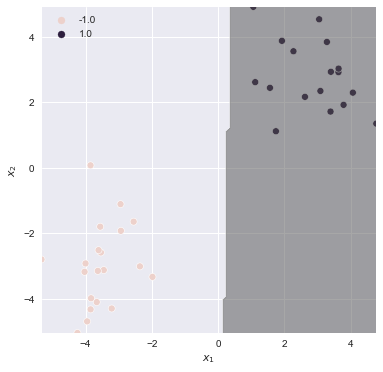

In [17]:
perceptron_obj = Perceptron()
perceptron_obj.train(x_train, y_train, lr=1)
visualize_model(x_train, y_train, perceptron_obj, degree=1)

In [18]:
perceptron_obj.error_all

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Let's look at the learning curve:

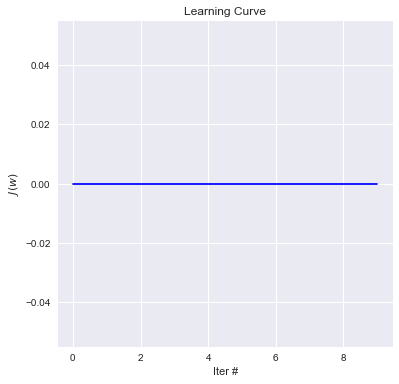

In [19]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(len(perceptron_obj.error_all)), perceptron_obj.error_all, 'b-')
plt.xlabel("Iter #")
plt.ylabel("$J(w)$")
plt.title("Learning Curve")
plt.show()

### Demo 2: Linearly inseparable Case

In [20]:
x,y = create_toy_data(factor=0.5)
x_poly = polynomial_transform(x, degree=1)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

perceptron_obj = Perceptron()
perceptron_obj.train(x_train, y_train, lr=1)

w:  [ 0.         -0.20445729  2.5761775 ]
J(w) 2.0
w:  [2.         1.28105826 3.36561549]
J(w) 2.0
w:  [0.         2.93643174 2.84286459]
J(w) 3.0
w:  [2.         1.59044505 1.51156108]
J(w) 1.0
w:  [2.         0.34616552 3.49818264]
J(w) 3.0
w:  [0.         3.32785621 4.00149667]
J(w) 2.0
w:  [2.         3.75745882 4.04104261]
J(w) 1.0
w:  [0.         1.43852411 1.53303241]
J(w) 3.0
w:  [0.         0.57149973 1.02269706]
J(w) 1.0
w:  [2.         1.91448962 3.74953554]
J(w) 1.0


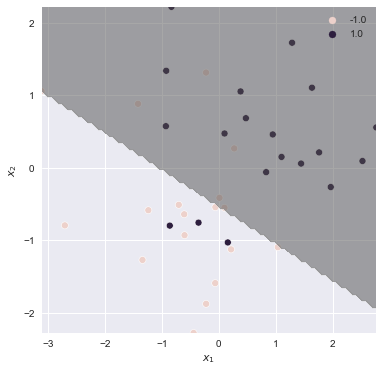

In [21]:
visualize_model(x_train, y_train, perceptron_obj, degree=1)

Looking at the learning curves again:

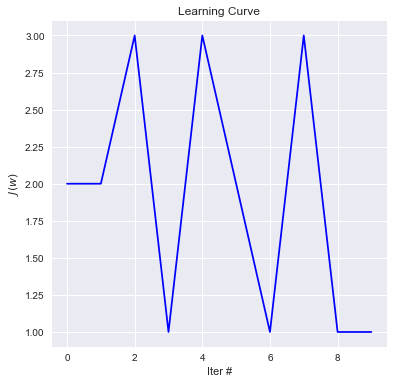

In [22]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(len(perceptron_obj.error_all)), perceptron_obj.error_all, 'b-')
plt.xlabel("Iter #")
plt.ylabel("$J(w)$")
plt.title("Learning Curve")
plt.show()

As we can see, the value of loss actually fluctuates a lot when data isn't perfectly separable.

### Demo 3: Linearly inseparable Case

In this demonstration, we will generate points from two classes such that the decision boundary between them is circular. We will make use of `sklearn.datasets` module to generate the synthetic examples. Specifically, we will use `make_circles` method.

In [23]:
from sklearn.datasets import make_circles
x,y = make_circles()

We will first transform the feature set to obtain polynomial features of degree $2$ and then train least square classifcation on theh transformed feature set.

> Note: We will generally not know with degree to try out for best possible results. So, we will have to use use various learning curves to actually tune the `degree`. But in this case we know for sure that `degree = 2` will suffice, because the decision boundary is circular in nature.

We first implement the `polynomial_transform` function.

In [24]:
import itertools,functools

def get_combinations(x, degree):
    '''
    Return successive r-length combinations of elements in the iterable allowing individual elements to have successive repeats.

    combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC"
    '''
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    '''
    reduce(function, sequence[, initial]) -> value

    Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.

    For example: 
    reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates ((((1+2)+3)+4)+5). 
    
    If initial is present, it is placed before the items of the sequence in the calculation, and serves as a default when the sequence is empty.

    reduce(lambda x,y: x*y, [1, 2, 3, 4, 5]) calculates ((((1*2)*3)*4)*5).
    '''
    return functools.reduce(lambda x, y: x*y, items)

def polynomial_transform(x, degree, logging=False):
    '''
    Steps for generating polynomial transformations of degree M ---
        
        1. Generate combination of input features of lengths = {0,1,...,M}.
        
        2. Perform multiplication operation between features to obtain the required new features.
    
    logging: Bool - True to print all the combinations and their products.
    '''
    
    # If 'x' is 1-dim, it is first converted to a feature matrix.
    # [1,2,3,4] to [[1],[2],[3],[4]]
    if x.ndim == 1:
        x = x[:,None]
    
    # Transpose of feature matrix
    x_t = x.transpose()

    # Populates 1's as first feature for each example, the degree 0 feature.
    features  = [np.ones(len(x))]

    if logging:
        print("Input: ",x)
    
    # for each degree d
    for d in range(1, degree+1):
        # generate combinations of degree d
        for x in get_combinations(x_t, d):
            # take product of no.s in x, and combine them into a single feature
            features.append(compute_new_feature(x))
            if logging:
                print(x,compute_new_feature(x), sep = ': ')
    
    if logging:
        print("Output: ", np.asarray(features).transpose())
    
    return np.asarray(features).transpose()

In [25]:
x_poly = polynomial_transform(x, degree=2)

In [26]:
print("Shape of feature matrix before transformation: ", x.shape)
print("Shape of feature matrix after polynomial transformation of degree 2: ", x_poly.shape)

Shape of feature matrix before transformation:  (100, 2)
Shape of feature matrix after polynomial transformation of degree 2:  (100, 6)


In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_poly, y)

In [30]:
y_train[:5]

array([0, 0, 1, 0, 1])

Now, we pre-process the labels from $0, 1$ to $+1, -1$ inorder to use our perceptron.

For, that I define my own `label_binarizer` method.

In [29]:
def label_binarizer(y):
    '''This converts all labels of 1 -> +1 and all labels of 0 -> -1'''
    return np.where(y == 1, 1, -1)

In [31]:
y_train, y_test = label_binarizer(y_train), label_binarizer(y_test)

In [32]:
y_train[:5]

array([-1, -1,  1, -1,  1])

Let's visualize the training data.

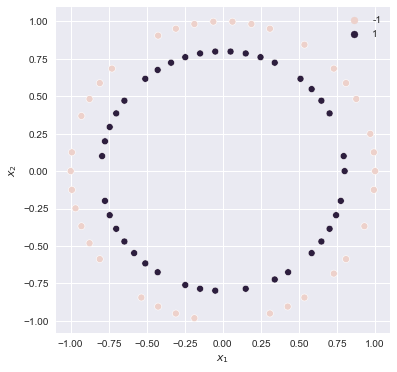

In [33]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=x_train, x=x_train[:,1], y=x_train[:,2], hue=y_train)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Let's build the perceptron model and visualize the training boundary and loss.

w:  [ 6.          0.60438286 -0.63853499 -2.83200166  0.98316752 -4.84799834]
J(w) 3
w:  [ 8.          0.69255383  0.36564107 -7.83553147 -0.67894358 -7.92446853]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0
w:  [  8.           0.18428638   0.43000461  -9.01874754  -1.28568611
 -10.34125246]
J(w) 0


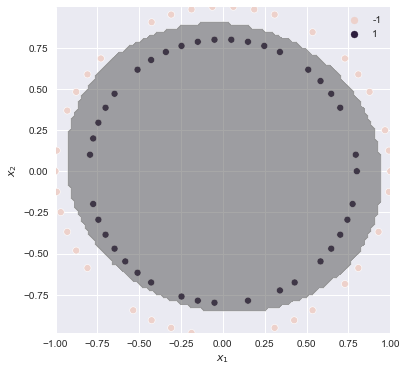

In [34]:
perceptron_obj_nl = Perceptron()
perceptron_obj_nl.train(x_train, y_train, lr=1)
visualize_model(x_train, y_train, perceptron_obj_nl, degree=2)

In [35]:
perceptron_obj_nl.error_all

[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Let's look at the learning curve.

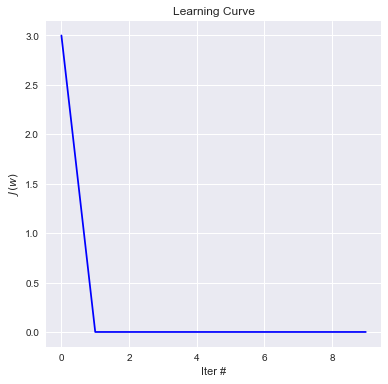

In [36]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(len(perceptron_obj_nl.error_all)), perceptron_obj_nl.error_all, 'b-')
plt.xlabel("Iter #")
plt.ylabel("$J(w)$")
plt.title("Learning Curve")
plt.show()

# Summary

- We implement the perceptron classifier from scratch.
- We look at 3 different cases and analyze those using our model:
    - First, when we have linearly separable data.
    - Second, when we have linearly inseparable data (with approximate linear boundary fit).
    - Third, when we have non-linearly separable data.
- We look at the learning curves and analyze the loss.
- We also visualize the decision boundary obtained by the model in each instance.